In [249]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
np.random.seed(42)
from IPython import display
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
sns.set();



In [61]:
ffmpeg_filepath="C:\\MSC_lectures\\Sem_4\\game_agent\\submission\\Intelligent_Agents_in_Gaming\\ffmpeg-4.4-full_build\\bin\\ffmpeg.exe"
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_filepath

In [3]:
# configurations 

#window size

x_limit=100
y_limit=100

# lost object cordinates 
#source_coordinated=[np.random.randint(int(x_limit/3),int(x_limit*2/3)),np.random.randint(int(y_limit/3),int(y_limit*2/3))]
source_coordinated=[60,40]
# population size and maximum number of steps per agent in a single trial 
population=10
steps=12


In [211]:
class Seeker:
    ''' Seeker class '''
    
    
    def __init__(self):
        
        self.personal_best=1e12   # initial personal best set to a larger value 
        self.personal_best_coordinates=(0,0) # place holder for the initial personal best coordinates
        
        
    def create_seeker(self,idx):
        '''create seeker in a random position (x,y) and assign initial velocity (Vx, Vy),
        assign a random values for parameters of particle swarm algorithem 
        Inertia weight (w)
        Cognitive coefficient (c1)
        Social coefficient (c2)'''
        
        self.idx=idx   # id of the seeker
        self.r = np.random.uniform(0,.25,2) 
        self.w = .5
        self.statues='not found'
        self.step=0
        self.generation=0
        self.color='blue'
        
        self.total_distance_traveled=0
        self.x= np.random.choice([0,x_limit],1)[0]
        self.y= np.random.choice([0,y_limit],1)[0]
        
        self.Vx= np.random.randint(5)*.001
        self.Vy= np.random.randint(5)*.001
        
        self.c1,self.c2=np.random.rand(2)
        
    def distance_to_source(self):
        ''' find the distance between source and the seeker location'''
        self.distance=((self.x-source_coordinated[0])**2+(self.y-source_coordinated[1])**2)**.5
    
    
    def update_personal_best(self):
        ''' update seekers personal best if the new distance if better than the previoues personal best  '''
        if self.personal_best >self.distance :
            self.personal_best=self.distance
            self.personal_best_coordinates=(self.x,self.y)
    
    
    def move(self,global_best_coordinates):
        ''' Calcualte new direction and the velocity of the seeker  '''  
        

        self.last_x=self.x
        self.last_y=self.y
        
        self.Vx = self.w*self.Vx + self.c1*self.r[0]*(self.personal_best_coordinates[0]-self.x)+  self.c2*self.r[1]*(global_best_coordinates[0]-self.x)
        self.x=self.Vx+self.x
      
        self.Vy = self.w*self.Vy + self.c1*self.r[0]*(self.personal_best_coordinates[1]-self.y)+  self.c2*self.r[1]*(global_best_coordinates[1]-self.y)
        self.y=self.Vy+self.y
        
    def distance_traveled(self):
        ''' calculate the distance to the source  '''
        distance_moved =  ((self.last_x-self.x)**2 + (self.last_y-self.y)**2)**.5
        self.total_distance_traveled=self.total_distance_traveled+ distance_moved

In [212]:
def update_global_best_location(rescue_team,global_best_location,global_best_coordinates):
    ''' update global best location of a seeker if it is closser to the source than the previous steps  '''
    global_location_list=[]
    for seeker in rescue_team:
        global_location_list.append(seeker.distance)
    new_global_best_location=min(global_location_list)
    
    if global_best_location>=new_global_best_location:
        global_best_location=new_global_best_location
        global_best_location_id=np.argmin(global_location_list)
        global_best_coordinates=(rescue_team[global_best_location_id].x,rescue_team[global_best_location_id].y)
        return global_best_location,global_best_coordinates
    else:
        return global_best_location,global_best_coordinates

In [213]:
def new_parameters(old_c1,old_c2,new_c1,new_c2,previous_personal_best,new_personal_best):
    ''' greedy algorithem to update parameters if new personal best is better than previoues personal best, unless contiune with the same parameters'''
    if previous_personal_best>=new_personal_best:
        return new_c1,new_c2
    else:
        random_val=np.random.uniform(-1,1)
        return old_c1+random_val,old_c2+random_val

In [216]:
# Create a list of Seeker objects representing the rescue team members
rescue_team=[ Seeker() for i in range (population)]

# Lists and dictionaries to store various information for each generation
seeker_starting_points_tuple_list=[]
seeker_parameters_dict={}
rescue_team_locations_generation_dict={}
global_best_distance_generation_dict={}
generation_performance_dict={}
global_best_distance_dict={}
generation=0
run =True

# Main simulation loop
while run:
    rescue_team_locations_list=[]
    global_best_distance_list=[]
    
    for step in range(steps):
        seeker_new_location=[]
        if step==0:
            # Initialize seekers and store their starting points in the first step
            global_location_list=[]
            for  seeker_id,seeker in enumerate(rescue_team):
                    seeker.create_seeker(idx=seeker_id)
                    # Store starting points for the first generation
                    
                    if generation==0:
                        seeker_starting_points_tuple_list.append((seeker.x,seeker.y))
                        
                    # Reset seeker's position for subsequent generations
                    if generation>1:
                        seeker.x=seeker_starting_points_tuple_list[seeker_id][0]
                        seeker.y=seeker_starting_points_tuple_list[seeker_id][1]
                        
                        # Retrieve parameters from the previous generation
                        old_c1,old_c2 =seeker_parameters_dict[generation-2][seeker_id][0],seeker_parameters_dict[generation-2][seeker_id][1]
                        new_c1,new_c2 =seeker_parameters_dict[generation-1][seeker_id][0],seeker_parameters_dict[generation-1][seeker_id][1]
                        
                        # Retrieve personal best distances from the previous and current generations
                        previous_personal_best=generation_performance_dict[generation-2][seeker_id]
                        new_personal_best=generation_performance_dict[generation-1][seeker_id]
                        
                        # Calculate new parameters for the seeker
                        c1,c2 = new_parameters(old_c1,old_c2,new_c1,new_c2 ,previous_personal_best,new_personal_best)
                        seeker.c1=c1
                        seeker.c2=c2
                    
                    # Calculate distance to the source and update personal best
                    seeker.distance_to_source()
                    seeker.update_personal_best()
                    global_location_list.append(seeker.distance)
                    
                    # Store seeker's location and color information
                    seeker_location=[seeker.x,seeker.y,seeker.Vx,seeker.Vy]
                    seeker_location.append(seeker.color)
                    if len(seeker_location)<4:
                        seeker_location=[seeker.x,seeker.y,0,0]
                    seeker_new_location.append(seeker_location)
                    
            # Find the global best location and its coordinates
            global_best_location=min(global_location_list)
            global_best_location_id=np.argmin(global_location_list)
            global_best_coordinates=(rescue_team[global_best_location_id].x,rescue_team[global_best_location_id].y)

        else:
            # Move seekers and update their positions
            for  seeker in rescue_team:
                    if seeker.statues=='not found':
                        seeker.move(global_best_coordinates)
                    seeker.distance_to_source()
                    seeker.update_personal_best()
                    seeker.distance_traveled()
                    
                    if seeker.total_distance_traveled>50:
                        
                        seeker.r=[0,0]
                        seeker.w=0
                        seeker.color='yellow'
                    
                    
                    # Check for a winning condition
                    if seeker.personal_best <= 2.5:
                        seeker.color='green'
                        print('win')
                        seeker.statues='found'
                        seeker.step=step
                        seeker.generation=generation
                        run=False
                    
                    # Store seeker's location and update distance-related information
                    seeker_location=[seeker.x,seeker.y,seeker.Vx,seeker.Vy]
                    seeker_location.append(seeker.color)
                    seeker_new_location.append(seeker_location)
                    
            
            # Update global best location based on the new positions of seekers
            global_best_location,global_best_coordinates=update_global_best_location(rescue_team,global_best_location,global_best_coordinates)      
                
        # Store information for this step
        rescue_team_locations_list.append(seeker_new_location)
        global_best_distance_list.append(global_best_location)
    
    # Store information for the current generation
    personal_best_list=[seeker.total_distance_traveled for  seeker in rescue_team]
    generation_performance_dict[generation]=np.array(personal_best_list)
    global_best_distance_dict[generation]=global_best_distance_list
    if generation ==0:
        seeker_parameters_list=[]
        
        # Store seeker parameters for the current generation
        for  seeker in rescue_team:
            seeker_parameters_list.append((seeker.c1,seeker.c2,seeker.Vx,seeker.Vy))
        seeker_parameters_dict[generation]=seeker_parameters_list
    else:
        seeker_parameters_list=[]
        for  seeker in rescue_team:
            seeker_parameters_list.append((seeker.c1,seeker.c2,seeker.Vx,seeker.Vy))
        seeker_parameters_dict[generation]=seeker_parameters_list
    # Store information for visualization    
    rescue_team_locations_generation_dict[generation]=rescue_team_locations_list
    global_best_distance_generation_dict[generation]=global_best_distance_list
    
    # Move to the next generation
    generation = generation+1
    
    # Terminate the simulation after a certain number of generations
    if generation>=50:
        run=False

win
win
win
win
win
win
win
win
win
win


In [217]:
for seeker in rescue_team:
    if seeker.statues == 'found':
        print(seeker.generation,seeker.step,seeker.total_distance_traveled)

48 11 473.18392089434525


plt.figure(figsize=(10,7))
for key, item in global_best_distance_dict.items():
    #if (key+1)%5==0:
        plt.plot(item[5:20], label=key+1)
plt.legend()

In [145]:
cmap=plt.cm.get_cmap('Paired', generation)

In [146]:
label_list=['gen_{}'.format(i) for i in range(generation)]

In [147]:
handles = [plt.Line2D([], [], color=cmap(i), label=label) for i,label in enumerate(label_list)]

In [148]:
# Create a figure with two subplots
fig, ax = plt.subplots(1,2,figsize=(14,7))




def update(frame):
    # Calculate the generation and frame count based on the current frame number
    gen_count = frame // steps
    gen_count=frame//steps
    frame_count=frame%steps
    
    # Clear the first subplot (agent movement) for updating
    ax[0].cla()
    
    # Plot agents and source for the current frame
    for seeker in rescue_team_locations_generation_dict[gen_count][frame_count]:
        ax[0].scatter(seeker[0],seeker[1],color=seeker[-1])
        ax[0].quiver(seeker[0],seeker[1], seeker[2],seeker[3], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
        ax[0].set_xlim(0,x_limit)
        ax[0].set_ylim(0,y_limit)
    
    # Add source and a circle representing the target area
    ax[0].set_title('Agent Movement- Generation {}'.format(gen_count))
    ax[0].scatter(source_coordinated[0],source_coordinated[1],marker='*',s=100,color='red')
    Circle=plt.Circle((source_coordinated[0],source_coordinated[1]), 2.5, color='green', fill=False)
    ax[0].add_patch(Circle)
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    
    # Plot the best global distance for the current generation and frame
    ax[1].plot(global_best_distance_generation_dict[gen_count][:frame_count],color=cmap(gen_count),linestyle='--' )
    ax[1].set_title('Best Global Distance')
    ax[1].set_ylabel('Distance (units)')
    ax[1].set_xlabel('Agent Steps Count')
    
    # Add legend for generations at the beginning of each generation
    if frame%steps==0:
        ax[1].legend(loc=1,labels=label_list[:gen_count+1],handles=handles[:gen_count+1]);
    
    # Increase generation count at the beginning of each generation
    if frame%steps==0:
        gen_count=gen_count+1
        

ani = animation.FuncAnimation(fig=fig, func=update, frames=steps*generation, interval=200)
video = ani.to_html5_video()
html=display.HTML(video)
display.display(html)
# Close the plot to prevent multiple plots from being displayed
plt.close()


# Experiment 

In [219]:
successful_gen=[]
step_count=[]
exp_id=[]
total_distance_travled=[]
seeker_id_list=[]
w_list =[]
c1_list=[]
c2_list=[]
r1_list=[]
r2_list=[]
for exp in range(50):    
    # Create a list of Seeker objects representing the rescue team members
    rescue_team=[ Seeker() for i in range (population)]

    # Lists and dictionaries to store various information for each generation
    seeker_starting_points_tuple_list=[]
    seeker_parameters_dict={}
    rescue_team_locations_generation_dict={}
    global_best_distance_generation_dict={}
    generation_performance_dict={}
    global_best_distance_dict={}
    generation=0
    run =True

    # Main simulation loop
    while run:
        rescue_team_locations_list=[]
        global_best_distance_list=[]

        for step in range(steps):
            seeker_new_location=[]
            
            if step==0:
                # Initialize seekers and store their starting points in the first step
                global_location_list=[]
                for  seeker_id,seeker in enumerate(rescue_team):
                        seeker.create_seeker(idx=seeker_id+1)
                        # Store starting points for the first generation

                        if generation==0:
                            seeker_starting_points_tuple_list.append((seeker.x,seeker.y))

                        # Reset seeker's position for subsequent generations
                        if generation>1:
                            seeker.x=seeker_starting_points_tuple_list[seeker_id][0]
                            seeker.y=seeker_starting_points_tuple_list[seeker_id][1]

                            # Retrieve parameters from the previous generation
                            old_c1,old_c2 =seeker_parameters_dict[generation-2][seeker_id][0],seeker_parameters_dict[generation-2][seeker_id][1]
                            new_c1,new_c2 =seeker_parameters_dict[generation-1][seeker_id][0],seeker_parameters_dict[generation-1][seeker_id][1]

                            # Retrieve personal best distances from the previous and current generations
                            previous_personal_best=generation_performance_dict[generation-2][seeker_id]
                            new_personal_best=generation_performance_dict[generation-1][seeker_id]

                            # Calculate new parameters for the seeker
                            c1,c2 = new_parameters(old_c1,old_c2,new_c1,new_c2 ,previous_personal_best,new_personal_best)
                            seeker.c1=c1
                            seeker.c2=c2

                        # Calculate distance to the source and update personal best
                        seeker.distance_to_source()
                        seeker.update_personal_best()
                        global_location_list.append(seeker.distance)

                        # Store seeker's location and color information
                        seeker_location=[seeker.x,seeker.y,seeker.Vx,seeker.Vy]
                        seeker_location.append(seeker.color)
                        if len(seeker_location)<4:
                            seeker_location=[seeker.x,seeker.y,0,0]
                        seeker_new_location.append(seeker_location)

                # Find the global best location and its coordinates
                global_best_location=min(global_location_list)
                global_best_location_id=np.argmin(global_location_list)
                global_best_coordinates=(rescue_team[global_best_location_id].x,rescue_team[global_best_location_id].y)

            else:
                # Move seekers and update their positions
                for  seeker in rescue_team:
                        
                        if seeker.statues=='not found':
                            seeker.move(global_best_coordinates)
                        
                        
                        # Store seeker's location and update distance-related information
                        seeker_location=[seeker.x,seeker.y,seeker.Vx,seeker.Vy]
                        seeker_location.append(seeker.color)
                        seeker_new_location.append(seeker_location)
                        
                        #print(f'outer step {step} ')
                        if seeker.statues!='found':
                            seeker.distance_traveled()
                            seeker.update_personal_best()
                            seeker.distance_to_source()
                            
                            
                        if seeker.total_distance_traveled>50:

                            seeker.r=[0,0]
                            seeker.w=0
                            seeker.color='yellow'
                            
                        # Check for a winning condition
                        
                        elif seeker.personal_best <= 2.5 and seeker.total_distance_traveled<=50: 
                            seeker.color='green'
                            seeker.statues='found'
                            
                            #print(f'innter step {seeker.step} seeker {seeker.idx} , gen {generation}')
                            seeker.generation=generation
                            run=False
                            

                # Update global best location based on the new positions of seekers
                global_best_location,global_best_coordinates=update_global_best_location(rescue_team,global_best_location,global_best_coordinates)      

            # Store information for this step
            rescue_team_locations_list.append(seeker_new_location)
            global_best_distance_list.append(global_best_location)

        # Store information for the current generation
        personal_best_list=[seeker.total_distance_traveled for  seeker in rescue_team]
        generation_performance_dict[generation]=np.array(personal_best_list)
        global_best_distance_dict[generation]=global_best_distance_list
        if generation ==0:
            seeker_parameters_list=[]

            # Store seeker parameters for the current generation
            for  seeker in rescue_team:
                seeker_parameters_list.append((seeker.c1,seeker.c2,seeker.Vx,seeker.Vy))
            seeker_parameters_dict[generation]=seeker_parameters_list
        else:
            seeker_parameters_list=[]
            for  seeker in rescue_team:
                seeker_parameters_list.append((seeker.c1,seeker.c2,seeker.Vx,seeker.Vy))
            seeker_parameters_dict[generation]=seeker_parameters_list
        # Store information for visualization    
        rescue_team_locations_generation_dict[generation]=rescue_team_locations_list
        global_best_distance_generation_dict[generation]=global_best_distance_list

        # Move to the next generation
        generation = generation+1

        # Terminate the simulation after a certain number of generations
        if generation>=50:
            run=False
    print(f'experiment {exp}')
    simulation_fail=0
    for seeker in rescue_team:
            if seeker.statues == 'found':
                print(seeker.generation,seeker.step,seeker.total_distance_traveled)
                successful_gen.append(seeker.generation)
                step_count.append(seeker.step)
                exp_id.append(exp)
                seeker_id_list.append(seeker.idx)
                total_distance_travled.append(seeker.total_distance_traveled)
                w_list.append(seeker.w) 
                c1_list.append(seeker.c1)
                c2_list.append(seeker.c2)
                r1_list.append(seeker.r[0])
                r2_list.append(seeker.r[1])
            else:
                simulation_fail =simulation_fail+1
            if simulation_fail==population:
                successful_gen.append(np.NaN)
                step_count.append(np.NaN)
                seeker_id_list.append(np.NaN)
                exp_id.append(exp)
                total_distance_travled.append(np.NaN)
                w_list.append(np.NaN)
                c1_list.append(np.NaN)
                c2_list.append(np.NaN)
                r1_list.append(np.NaN)
                r2_list.append(np.NaN)
                print('experiment faild')
    print('-------------')

innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
innter step 0 seeker 4 , gen 30
experiment 0
30 0 5.79520030869707
-------------
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
innter step 0 seeker 3 , gen 44
experiment 1
44 0 0.6154865782533914
-------------
innter step 0 seeker 1 , gen 5
innter step 0 seeker 1 , gen 5
innter step 0 seeker 1 , gen 5
innter step 0 seeker 1 , gen 5
innter step 0 seeker 1 , gen 5
innter step 0 seeker 1 , gen 5
innter ste

In [277]:
results=pd.DataFrame({'experiment_id':exp_id ,'seeker_id':seeker_id_list,'successful_generation':successful_gen,'total_distance_travled':total_distance_travled,
                        'c1':c1_list,
                        'c2':c2_list,
                        'r1':r1_list,
                        'r2':r2_list})

In [278]:
results.loc[  results[results.seeker_id.isna()].index,'experiment_outcome']='Not_Found'
results.loc[  results[~results.seeker_id.isna()].index,'experiment_outcome']='Found'

In [279]:
results.columns

Index(['experiment_id', 'seeker_id', 'successful_generation',
       'total_distance_travled', 'c1', 'c2', 'r1', 'r2', 'experiment_outcome'],
      dtype='object')

In [280]:
results[['successful_generation',
       'total_distance_travled', 'c1', 'c2', 'r1', 'r2', 'experiment_outcome']].describe()

,successful_generation,total_distance_travled,c1,c2,r1,r2
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,17.400000,7.631599,0.974930,1.062169,0.124015,0.131028
std,14.149024,8.133378,0.948330,0.941338,0.072821,0.073192
min,2.000000,0.438248,-0.795083,-1.007494,0.016408,0.003218
25%,5.000000,1.599950,0.408333,0.316275,0.069224,0.074253
50%,12.500000,5.229437,0.893758,1.137329,0.117044,0.131868
75%,26.000000,10.537715,1.577670,1.554036,0.184509,0.205817
max,49.000000,39.247916,3.594018,3.729169,0.249325,0.239371


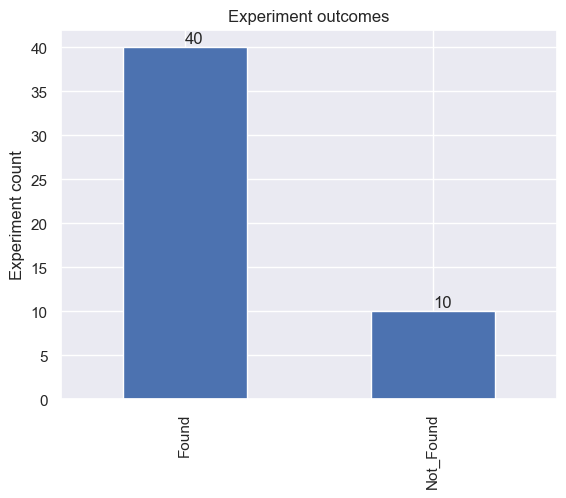

In [281]:
ax=results.experiment_outcome.value_counts().plot(kind='bar');
val1=results.experiment_outcome.value_counts()[0]
val2=results.experiment_outcome.value_counts()[1]
ax.text(0,val1+.5,str(val1))
ax.text(1,val2+.5,str(val2))
plt.title('Experiment outcomes');
plt.ylabel('Experiment count');

In [282]:
def distribution_plot(X,title,xlabel):
    fig,axs=plt.subplots(1,2,figsize=(12,6))
    sns.histplot(X,ax=axs[0]);
    sns.ecdfplot(X,ax=axs[1]);
    fig.suptitle(title);
    for ax in axs:
        ax.set_xlabel(xlabel);

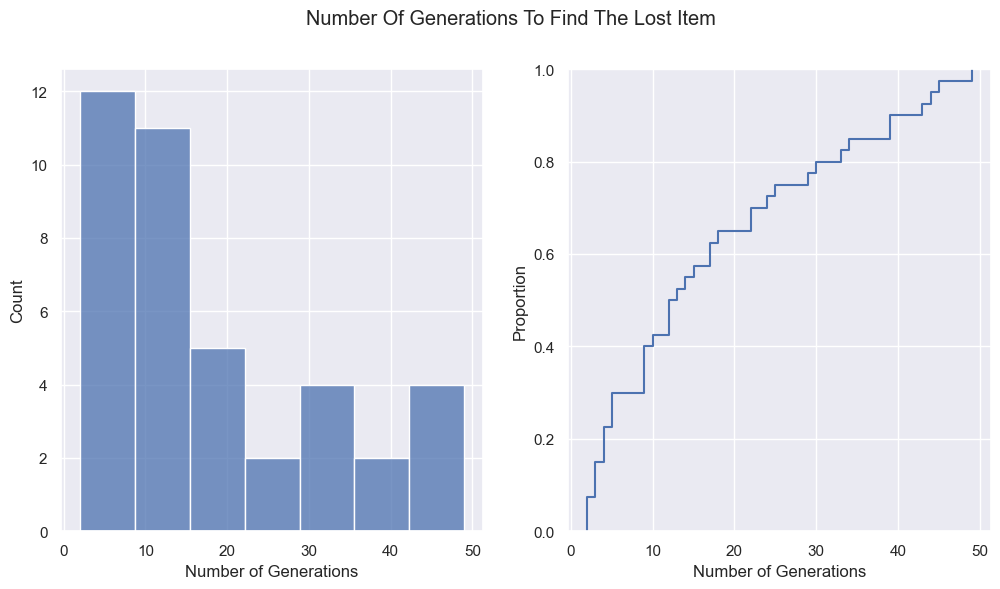

In [283]:
distribution_plot(results.successful_generation,'Number Of Generations To Find The Lost Item','Number of Generations')

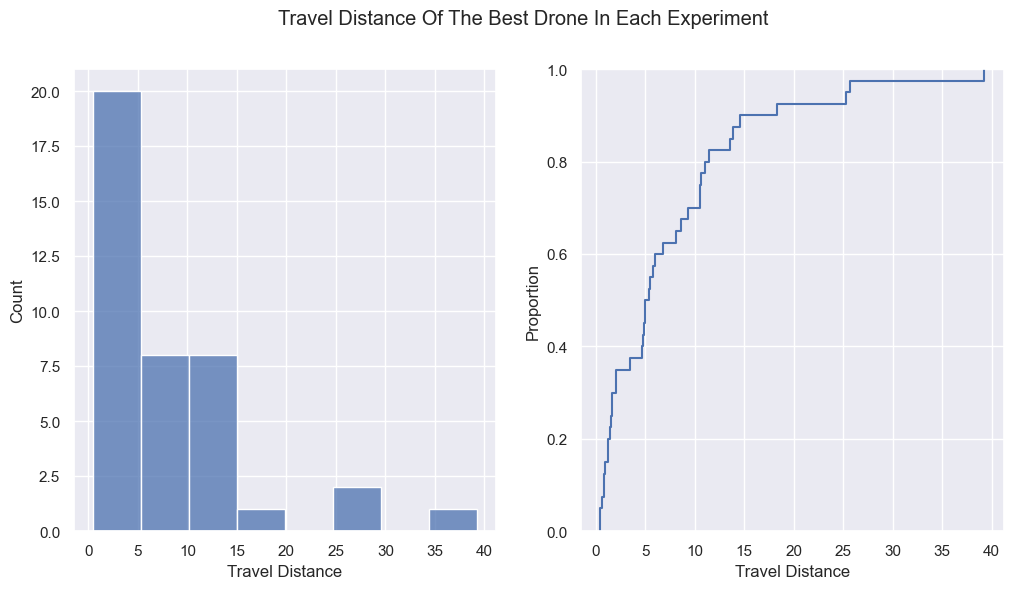

In [284]:
distribution_plot(results.total_distance_travled,'Travel Distance Of The Best Drone In Each Experiment','Travel Distance')

In [301]:
results.columns

Index(['experiment_id', 'seeker_id', 'successful_generation',
       'total_distance_travled', 'c1', 'c2', 'r1', 'r2', 'experiment_outcome'],
      dtype='object')

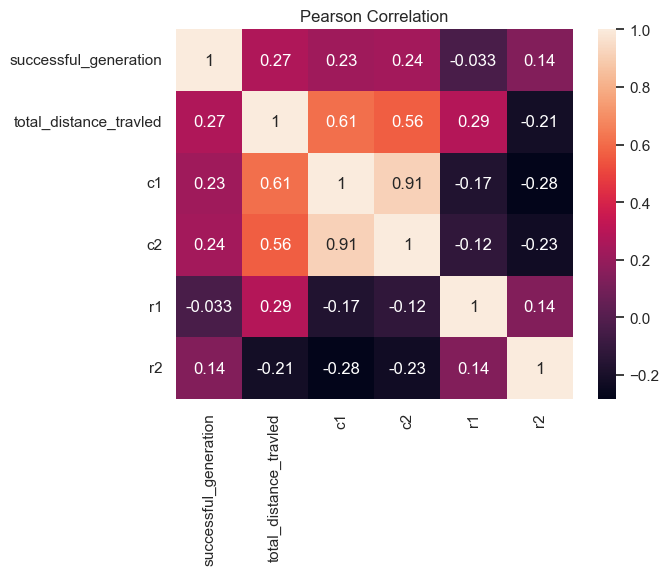

In [302]:
sns.heatmap(results[['successful_generation','total_distance_travled', 'c1', 'c2', 'r1', 'r2',]].corr(),annot=True).set_title('Pearson Correlation');

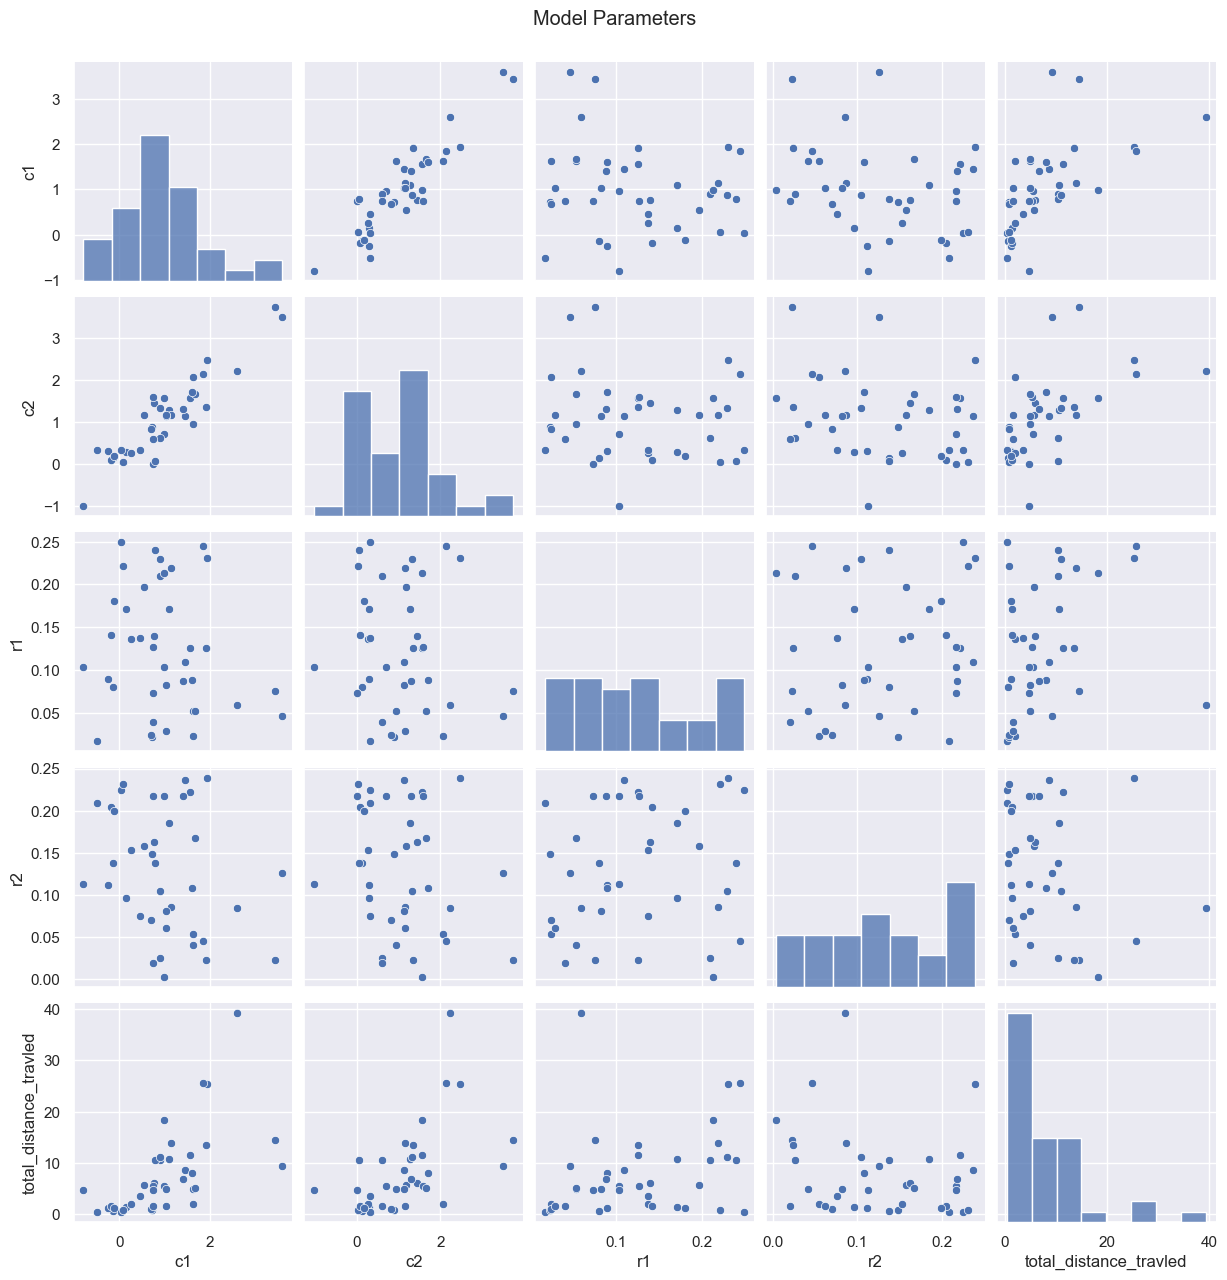

In [297]:
pp=sns.pairplot(results[['c1', 'c2', 'r1', 'r2','total_distance_travled']]);
pp.fig.suptitle('Model Parameters',y=1.025);